In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf
import time

In [6]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,248.839996,4527600
2015-05-18,247.000000,249.899994,246.000000,248.750000,248.750000,3353200
2015-05-19,248.429993,251.000000,246.149994,247.139999,247.139999,3674200
2015-05-20,247.130005,247.740005,241.369995,244.350006,244.350006,3755600
2015-05-21,243.029999,246.619995,242.360001,245.619995,245.619995,1970600
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,819.419983,16130100
2020-05-11,790.510010,824.000000,785.000000,811.289978,811.289978,16471100
2020-05-12,827.000000,843.289978,808.000000,809.409973,809.409973,15906900


In [7]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = tesla
dataframe_tsla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

tesla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.130072,0.116005,0.133492,0.135922,0.135922,0.063416
2015-05-18,0.134002,0.116619,0.138098,0.135806,0.135806,0.043918
2015-05-19,0.135833,0.117970,0.138295,0.133725,0.133725,0.049247
2015-05-20,0.134169,0.113965,0.132005,0.130120,0.130120,0.050599
2015-05-21,0.128920,0.112589,0.133308,0.131761,0.131761,0.020963
...,...,...,...,...,...,...
2020-05-08,0.833931,0.821884,0.849981,0.873344,0.873344,0.256050
2020-05-11,0.829758,0.821884,0.847336,0.862837,0.862837,0.261712
2020-05-12,0.876469,0.845581,0.877600,0.860407,0.860407,0.252344


In [8]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
print(X_train.shape)


(200, 6, 1)


# LSTM Tuning:

In [9]:
# Model 1:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2148.340722799301 seconds 
Mean Validation loss= 0.01400029


In [15]:
# Model 2:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout=0.20))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2302.2270328998566 seconds 
Mean Validation loss= 0.01310031


In [16]:
# Model 3:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.20))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2185.9810297489166 seconds 
Mean Validation loss= 0.01206783


In [19]:
# Model 4:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True,dropout = 0.40))
model.add(LSTM(16,dropout = 0.10))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2243.919264793396 seconds 
Mean Validation loss= 0.07646143


In [20]:
# Model 5:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,1):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
time taken for execution : 538.3310439586639 seconds 
Mean Validation loss= 0.01203281


0.01203281


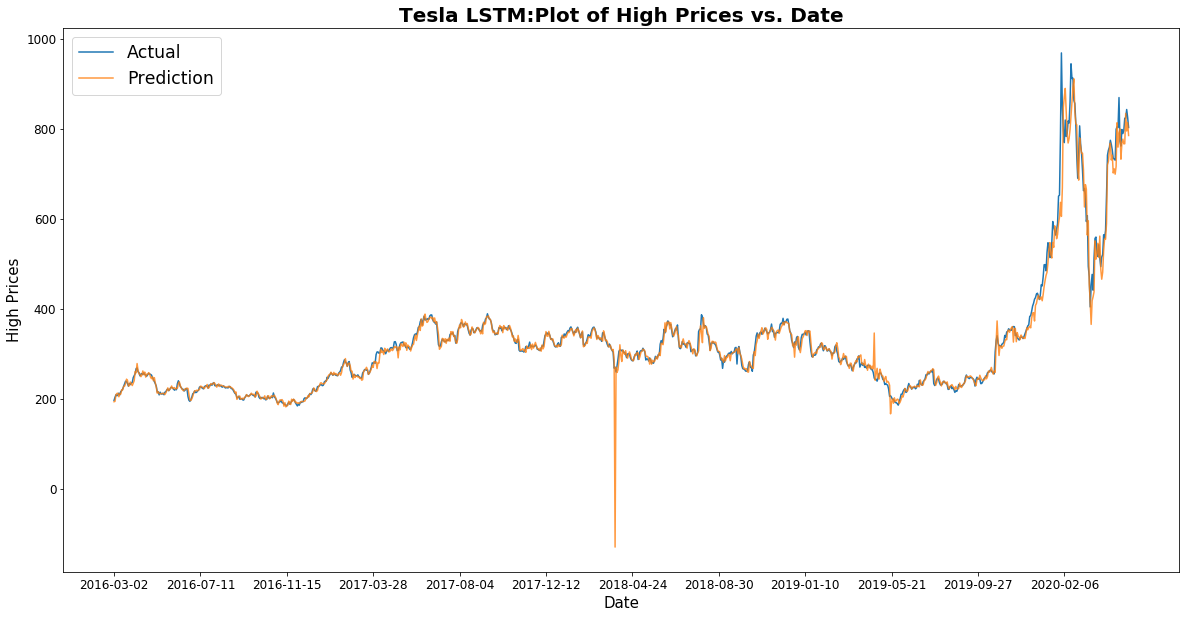

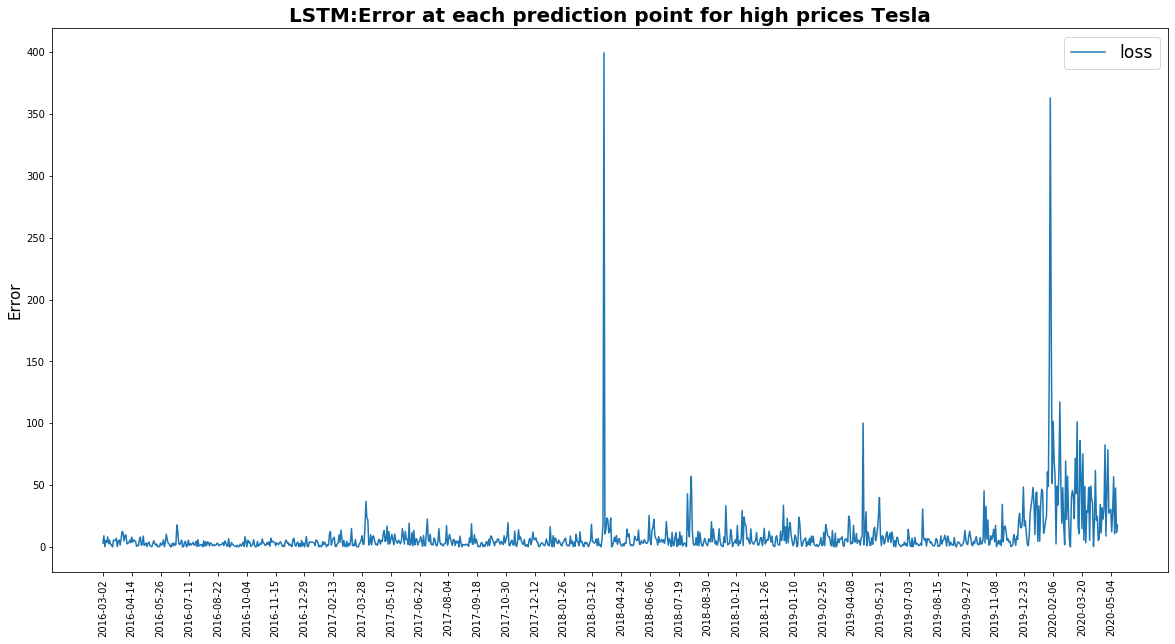

In [21]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
print(mean(val_loss))

def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")


def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")
 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))
title_str = 'Tesla LSTM:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)

title_str ='LSTM:Error at each prediction point for high prices Tesla'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)


In [30]:
print(predicted_low,actual_low)

[[186.35491144]
 [186.7121351 ]
 [202.0307531 ]
 ...
 [757.37435438]
 [779.93507642]
 [747.56992971]] [[184.220001]
 [197.5     ]
 [197.399994]
 ...
 [808.      ]
 [763.299988]
 [764.      ]]


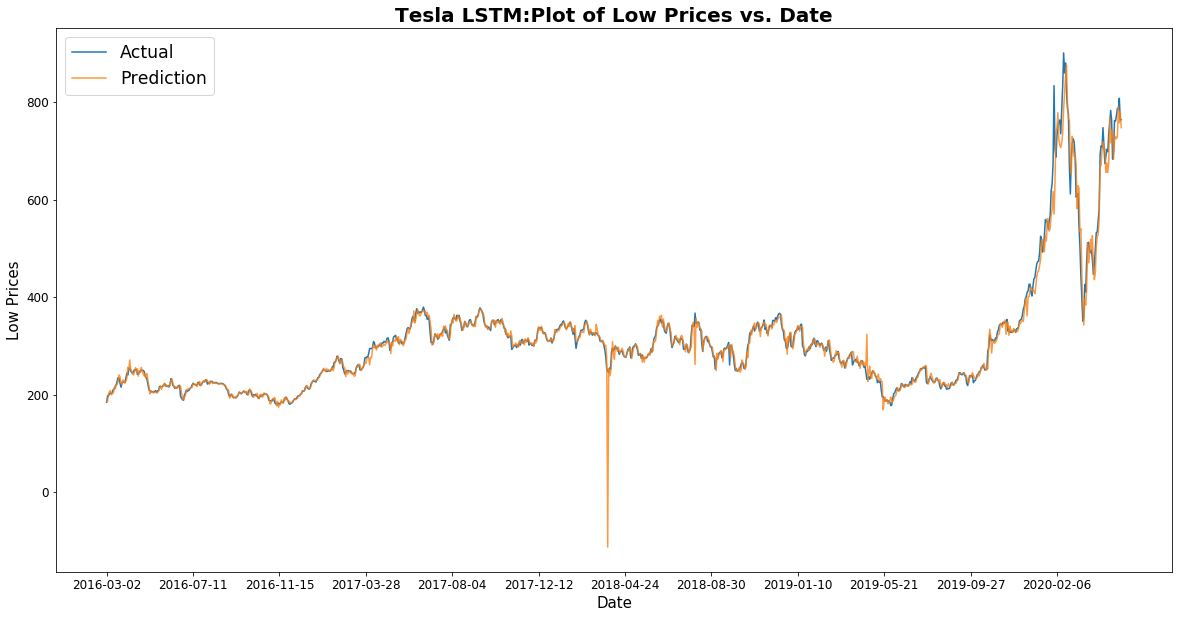

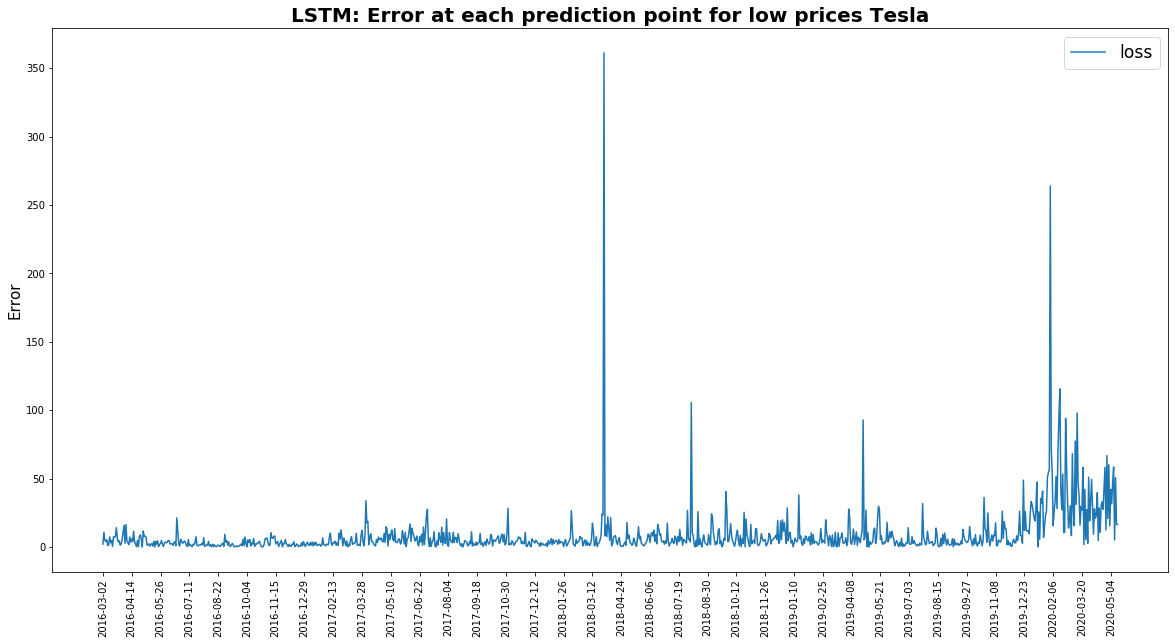

In [22]:
title_str = 'Tesla LSTM:Plot of Low Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_low,predicted_low ,np.array(predicted_dates),title_str,y_label )
title_str ='LSTM: Error at each prediction point for low prices Tesla'
mae(predicted_low,actual_low,np.array(predicted_dates),title_str)

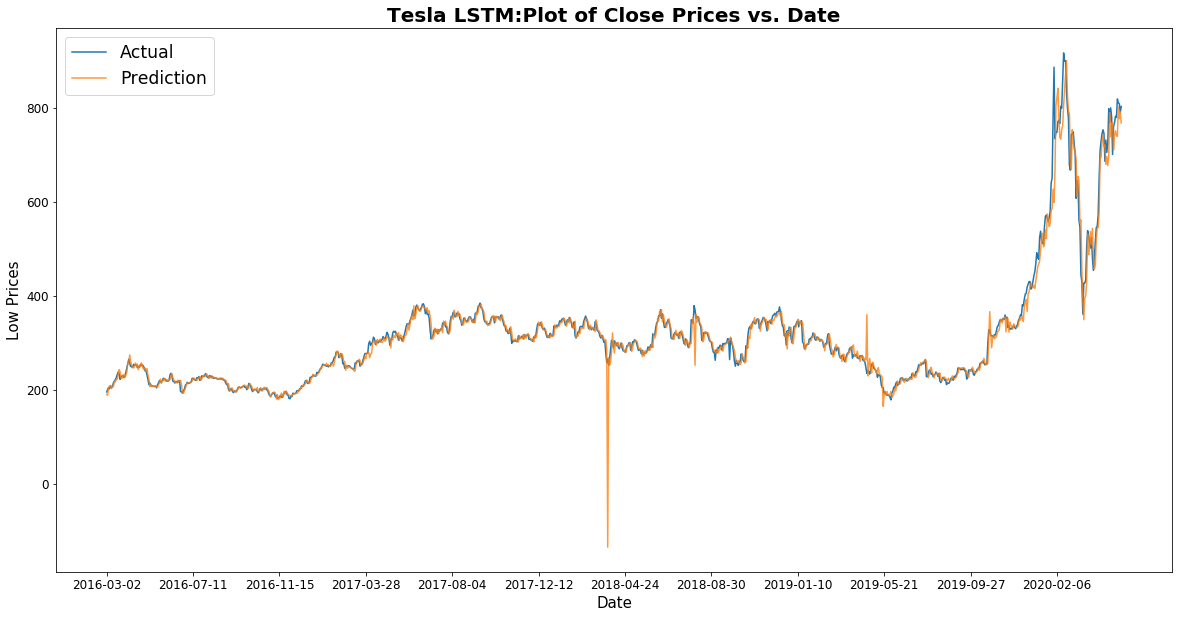

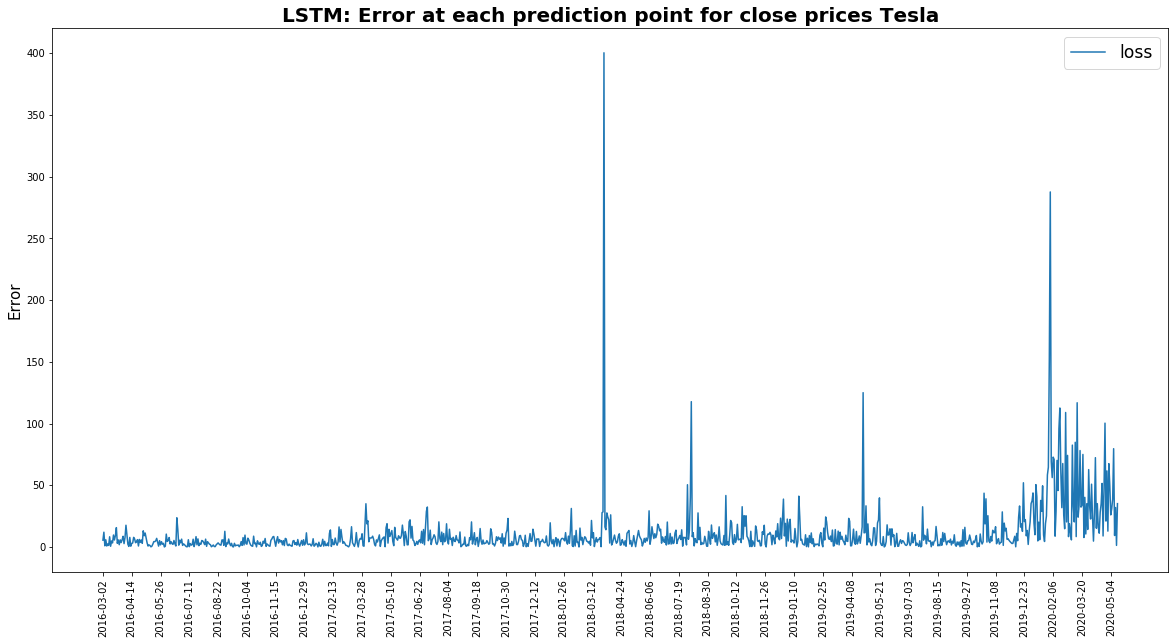

In [23]:
title_str = 'Tesla LSTM:Plot of Close Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_close,predicted_close ,np.array(predicted_dates),title_str,y_label )
title_str ='LSTM: Error at each prediction point for close prices Tesla'
mae(predicted_close,actual_close,np.array(predicted_dates),title_str)

<BarContainer object of 42 artists>

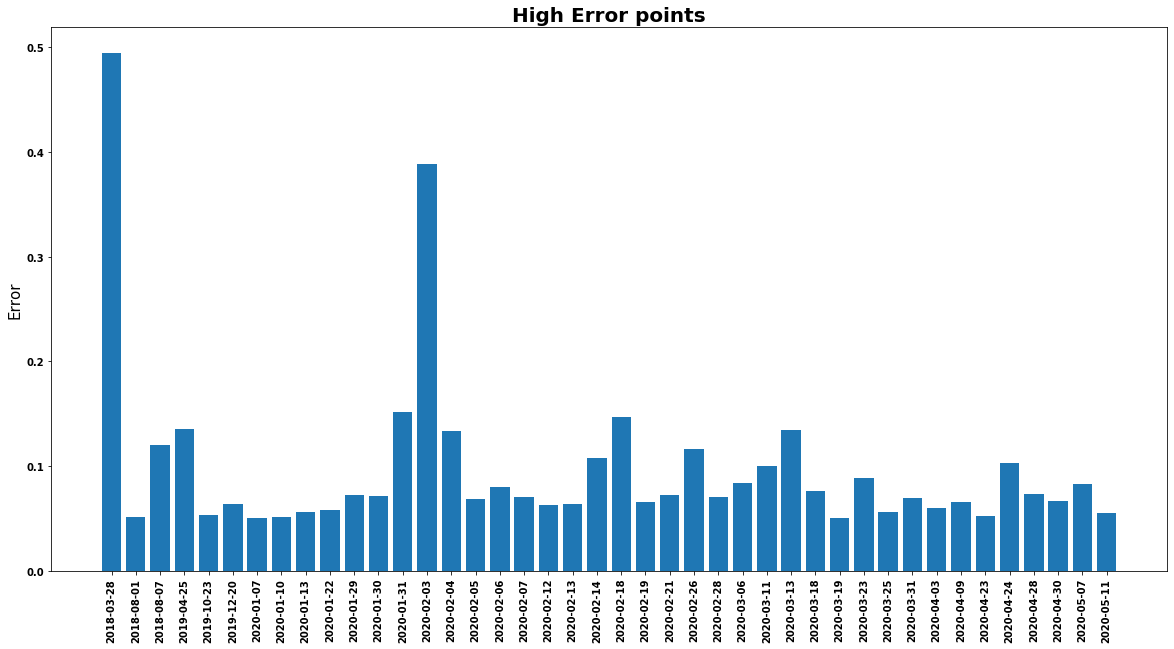

In [24]:
large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 2. Dow Jones Index:

In [31]:
#Convert Date Format:
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

#merge values:
tesla_dates = list(tesla.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(tesla_dates))
tesla["dow"] = mean_dow
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in dow_dates:
        tesla["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
tesla

198.285659767141 1259


,Open,High,Low,Close,Adj Close,Volume,dow
Date,,,,,,,
2015-05-15,0.130072,0.116005,0.133492,0.135922,0.135922,0.063416,209.91
2015-05-18,0.134002,0.116619,0.138098,0.135806,0.135806,0.043918,212.63
2015-05-19,0.135833,0.117970,0.138295,0.133725,0.133725,0.049247,213.62
2015-05-20,0.134169,0.113965,0.132005,0.130120,0.130120,0.050599,213.01
2015-05-21,0.128920,0.112589,0.133308,0.131761,0.131761,0.020963,211.42
...,...,...,...,...,...,...,...
2020-05-08,0.833931,0.821884,0.849981,0.873344,0.873344,0.256050,237.39
2020-05-11,0.829758,0.821884,0.847336,0.862837,0.862837,0.261712,244.15
2020-05-12,0.876469,0.845581,0.877600,0.860407,0.860407,0.252344,244.85


In [34]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_dow = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_dow.fit(np.array(data['dow']).reshape(-1, 1))
    data['dow'] =scaler_dow.transform(np.array(data['dow']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [35]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 3053.730931997299 seconds 
Mean Validation loss= 0.01467586


# 3. FTSE opening Index:

In [48]:
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla = tesla.drop(['Adj Close'], axis=1)
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)

#merge values:
tesla_dates = list(tesla.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
tesla["ftse"] = mean_ftse
#print(ftse)
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date,ftse['newOpen'][ftse['FormatDate']==date])
    if date in tesla_dates and len(ftse['newOpen'][ftse['FormatDate']==date])!=0 :
        #print(ftse['newOpen'][ftse['FormatDate']==date])
        tesla["ftse"][row_num] = mean(ftse['newOpen'][ftse['FormatDate']==date])
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,ftse
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,6973.000000
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,6960.000000
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,6968.000000
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,6995.000000
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,7007.000000
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,6982.075099
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,5936.000000
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,5939.000000


In [49]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
dataframe_tesla = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [50]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 2671.4446358680725 seconds 
Mean Validation loss= 0.01400811


# 4. S&P Global Oil Index:

In [51]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
tesla = tesla.drop(['Adj Close'], axis=1)
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)

#merge values:
tesla_dates = list(tesla.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
tesla["oil"] = mean_oil
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in oil_dates:
        tesla["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,oil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,1956.93
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,1948.25
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,1917.52
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,1916.57
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,1936.78
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,1082.50
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,1071.49
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,1062.24


In [54]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #S&P global Oil:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [55]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 2788.0657811164856 seconds 
Mean Validation loss= 0.01383611


# 5. S&P1000 Index:

In [57]:
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
#print(mean_sp,len(ford_dates))
tesla["S&P1000"] = mean_sp
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in sp1000_dates:
        tesla["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))

del tesla['Adj Close']
tesla

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,S&P1000
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,8627.79
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,8701.63
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,8689.52
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,8692.93
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,8697.50
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,9409.29
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,9309.29
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,8976.31


In [58]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #s&p 1000:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [59]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2206.807112932205 seconds 
Mean Validation loss= 0.01345921


# 6. Crude Oil Prices:

In [60]:
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)

#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
print(mean_cop,len(tesla_dates))
tesla["CrudeOil"] = mean_cop
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in cr_oil_dates:
        tesla["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))

del tesla['Adj Close']
tesla

52.015504169825626 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,CrudeOil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,59.69
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,59.43
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,57.26
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,58.98
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,60.72
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,24.74
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,24.14
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,25.78


In [61]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [62]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2206.60497713089 seconds 
Mean Validation loss= 0.01294703


# 7. Dow Jones Oil & Gas Supersector Titans Index:

In [63]:
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)
tesla = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/TSLA.csv', header=0, index_col=0)

#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)

#merge values:
tesla_dates = list(tesla.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
print(mean_top,len(tesla_dates))
tesla["TitanOil"] = mean_top
for row_num in range(0,len(tesla_dates)):
    date = tesla_dates[row_num] 
    #print(date)
    if date in titan_oil_dates:
        tesla["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
del tesla['Adj Close']
tesla

394.1362162162162 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,TitanOil
Date,,,,,,
2015-05-15,243.929993,249.399994,242.500000,248.839996,4527600,445.40
2015-05-18,247.000000,249.899994,246.000000,248.750000,3353200,443.20
2015-05-19,248.429993,251.000000,246.149994,247.139999,3674200,437.01
2015-05-20,247.130005,247.740005,241.369995,244.350006,3755600,437.22
2015-05-21,243.029999,246.619995,242.360001,245.619995,1970600,441.62
...,...,...,...,...,...,...
2020-05-08,793.770020,824.000000,787.010010,819.419983,16130100,267.26
2020-05-11,790.510010,824.000000,785.000000,811.289978,16471100,265.18
2020-05-12,827.000000,843.289978,808.000000,809.409973,15906900,262.17


In [64]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #crude oil prices:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close

df = tesla
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [65]:
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.005)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16,dropout = 0.30))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2242.6546397209167 seconds 
Mean Validation loss= 0.01370173
